In [20]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import os
import gzip

# Subtask 1

In [30]:
X = np.random.randn(1, 500)
countOfLayers = 10
countOfNeurons = 500

def plot_histogram(x, network):
    plt.figure(figsize=(22, 4))
    for i, layer in enumerate(network):
        x = layer(x)
        plt.subplot(1, 10, i+1)
        plt.hist(x.numpy().ravel(), bins=20)
        plt.xlim([-1.0, 1.0])
        plt.title('Layer {}'.format(i+1))
        
def network_creator(kernel_initializer, activation):
    layers = [
        keras.layers.Dense(
            units = countOfNeurons, 
            activation = activation, 
            kernel_initializer = kernel_initializer
        ) for _ in range(countOfLayers)
    ]
    return layers

def create_network_and_plot_histogram(kernel_initializer, activation):
    network = network_creator(kernel_initializer, activation)
    plot_histogram(X, network)

## Activation function: sigmoid

Initialize the weights to zero


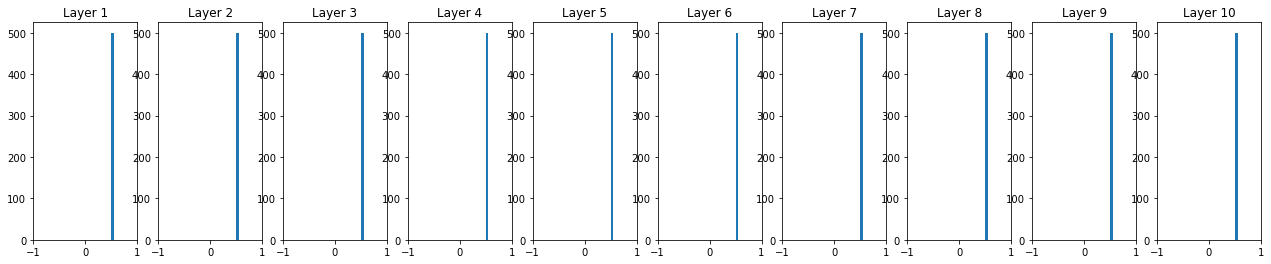

In [39]:
print("Initialize the weights to zero")
create_network_and_plot_histogram('zeros', 'sigmoid')

Initialize the weights to small random values


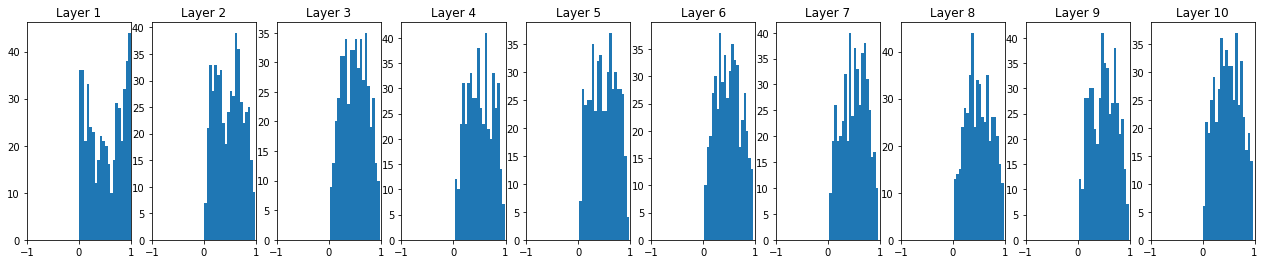

In [40]:
print("Initialize the weights to small random values")
create_network_and_plot_histogram(keras.initializers.normal(stddev=0.1), 'sigmoid')

Initialize the weights to big random values


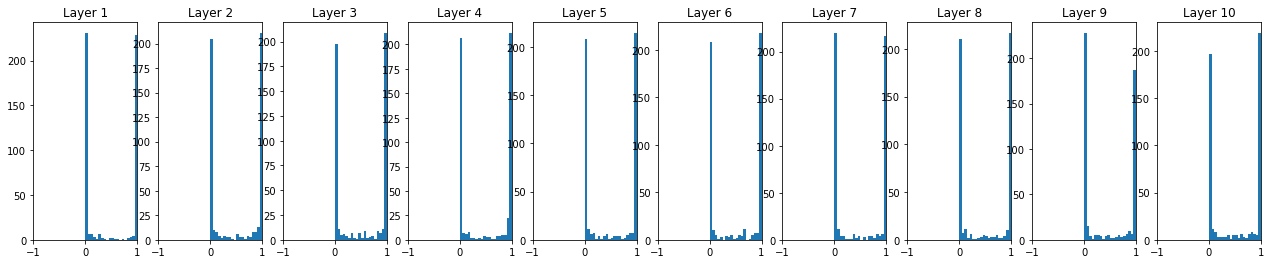

In [41]:
print("Initialize the weights to big random values")
create_network_and_plot_histogram(keras.initializers.normal(stddev=1.0), 'sigmoid')

Initialize the weights with Xavier initialization method


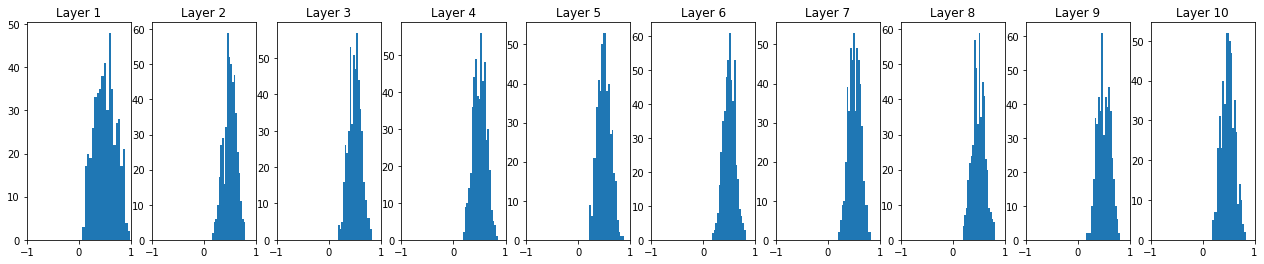

In [42]:
print("Initialize the weights with Xavier initialization method")
create_network_and_plot_histogram('glorot_normal', 'sigmoid')

Initialize the weights with He initialization method


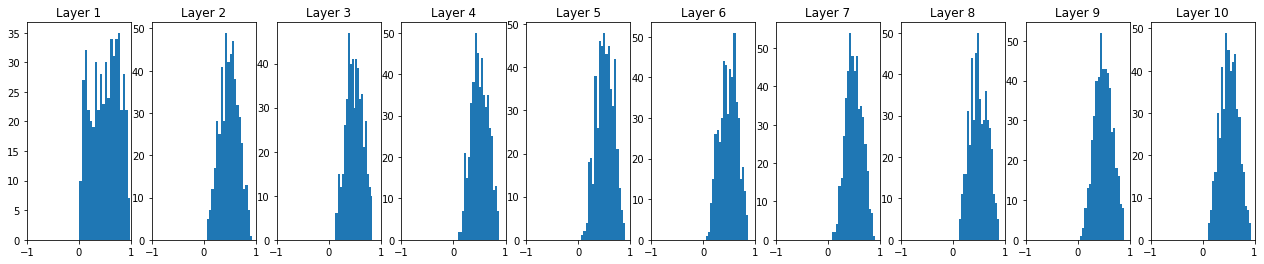

In [43]:
print("Initialize the weights with He initialization method")
create_network_and_plot_histogram('he_normal', 'sigmoid')

## Activation function: tanh

Initialize the weights to zero


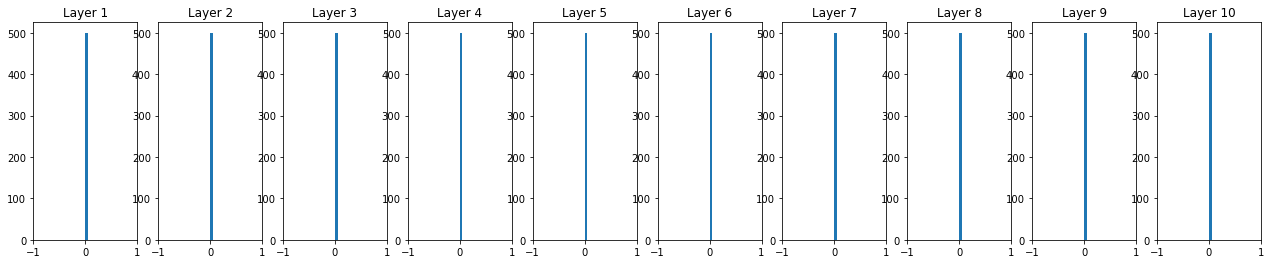

In [44]:
print("Initialize the weights to zero")
create_network_and_plot_histogram('zeros', 'tanh')

Initialize the weights to small random values


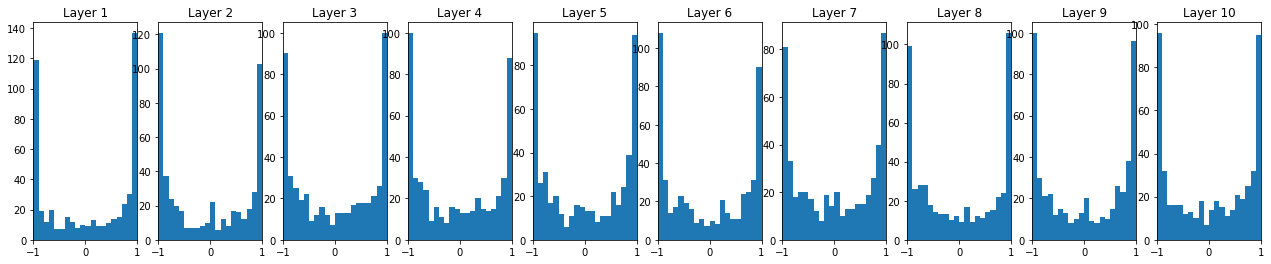

In [47]:
print("Initialize the weights to small random values")
create_network_and_plot_histogram(keras.initializers.normal(stddev=0.1), 'tanh')

Initialize the weights to big random values


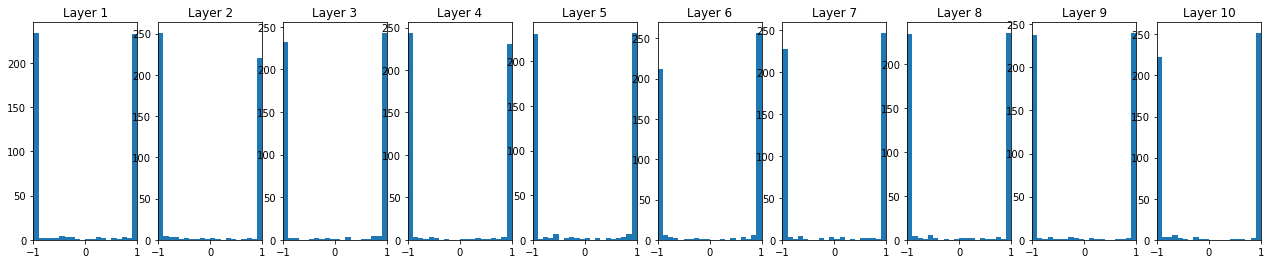

In [48]:
print("Initialize the weights to big random values")
create_network_and_plot_histogram(keras.initializers.normal(stddev=1.0), 'tanh')

Initialize the weights with Xavier initialization method


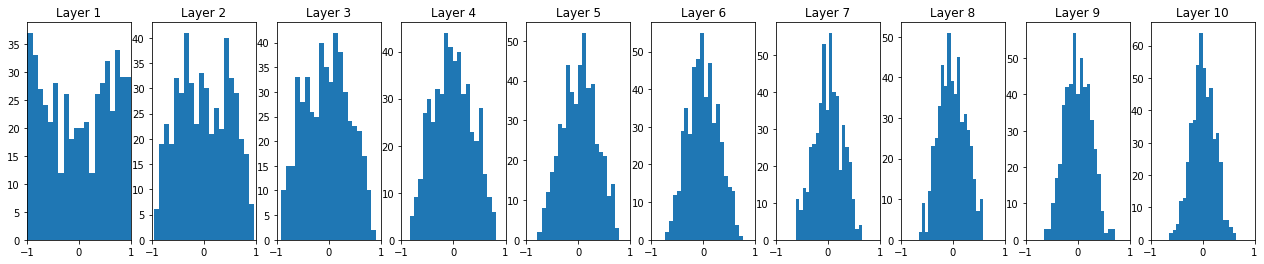

In [49]:
print("Initialize the weights with Xavier initialization method")
create_network_and_plot_histogram('glorot_normal', 'tanh')

Initialize the weights with He initialization method


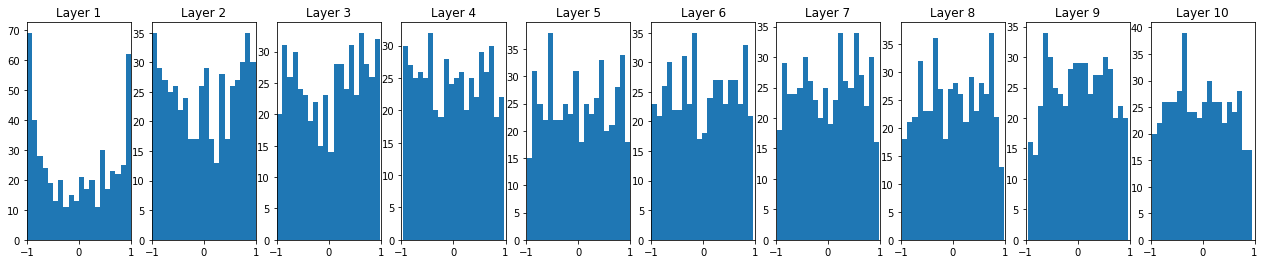

In [50]:
print("Initialize the weights with He initialization method")
create_network_and_plot_histogram('he_normal', 'tanh')

## Activation function: ReLU

Initialize the weights to zero


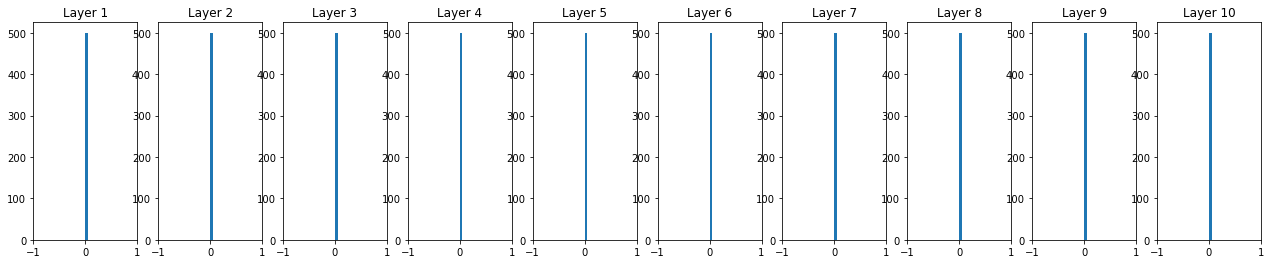

In [51]:
print("Initialize the weights to zero")
create_network_and_plot_histogram('zeros', 'relu')

Initialize the weights to small random values


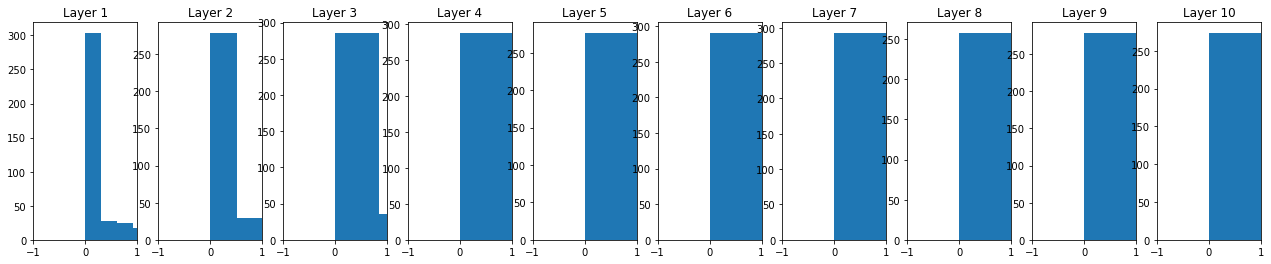

In [52]:
print("Initialize the weights to small random values")
create_network_and_plot_histogram(keras.initializers.normal(stddev=0.1), 'relu')

Initialize the weights to big random values


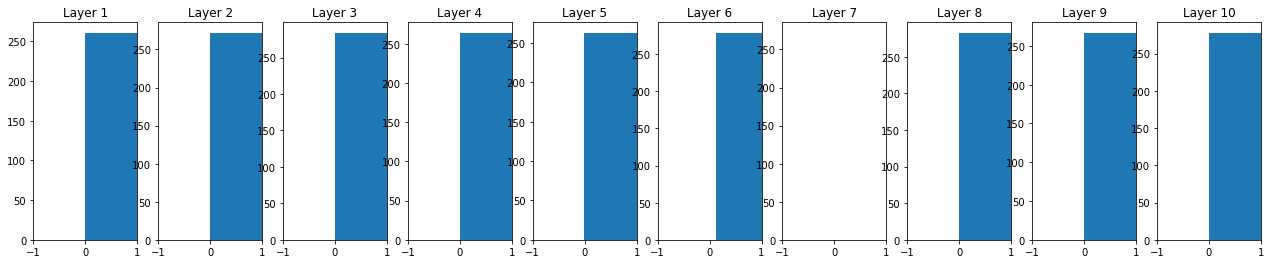

In [56]:
print("Initialize the weights to big random values")
create_network_and_plot_histogram(keras.initializers.normal(stddev=1.0), 'relu')

Initialize the weights with Xavier initialization method


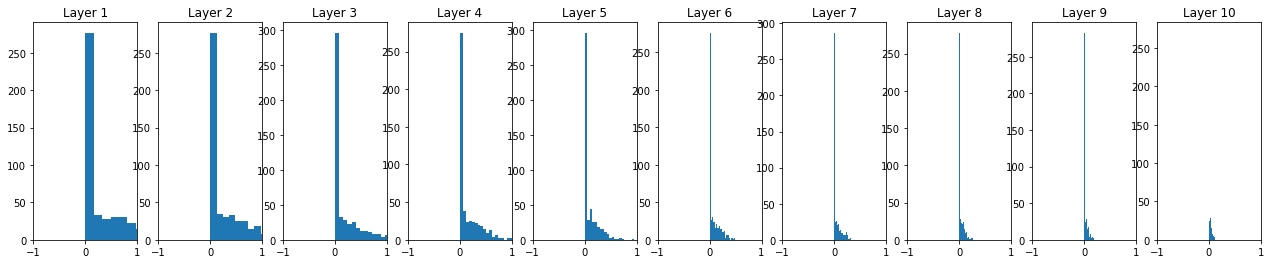

In [57]:
print("Initialize the weights with Xavier initialization method")
create_network_and_plot_histogram('glorot_normal', 'relu')

Initialize the weights with He initialization method


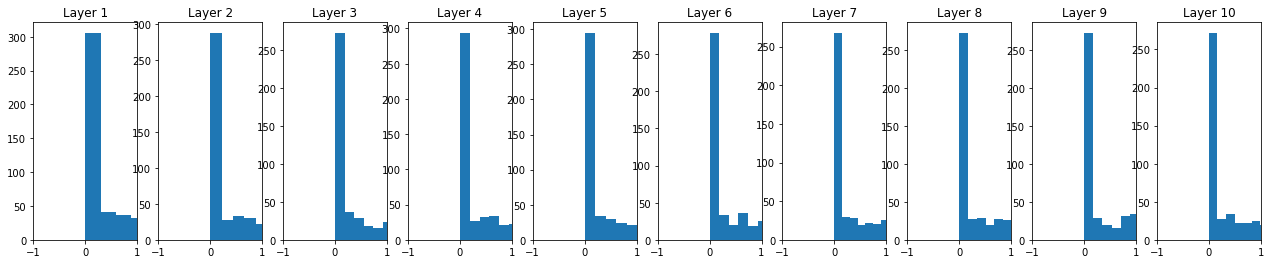

In [58]:
print("Initialize the weights with He initialization method")
create_network_and_plot_histogram('he_normal', 'relu')

# Subtask 2

## Read data

In [59]:
def read_data(path):
    if 'images' in path:
        elem_size, header_bytes = 28, 16
        type_ = np.float32
    else:
        elem_size, header_bytes = 1, 8
        type_ = np.uint8        
    if 't10k' in path:
        num = 10000
    else:
        num = 60000      
    f = gzip.open(path, 'r')
    f.read(header_bytes)
    shape = 1 if elem_size == 1 else (elem_size, elem_size)
    return np.array([
        np.frombuffer(
            f.read(elem_size*elem_size), 
            dtype=np.uint8
        ).astype(type_).reshape(shape)
        for _ in range(num)
    ])

def labels_to_one_hot(array):
    n = array.shape[0]
    res = np.zeros((n, 10))
    res[np.arange(n), array.ravel()] = 1
    return res

X_train = read_data("dataSet/train-images-idx3-ubyte.gz").reshape(-1, 784) / 255.
X_test = read_data("dataSet/t10k-images-idx3-ubyte.gz").reshape(-1, 784) / 255.
y_train = labels_to_one_hot(read_data("dataSet/train-labels-idx1-ubyte.gz"))
y_test = labels_to_one_hot(read_data("dataSet/t10k-labels-idx1-ubyte.gz"))

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (60000, 784)
X_test: (10000, 784)
y_train: (60000, 10)
y_test: (10000, 10)


## Network preparation

In [70]:
def softmax(x):
    exp_ = np.exp(x)
    return exp_ / np.sum(exp_, axis=0)

def d_softmax(x):
    y = softmax(x)
    n = y.shape[1]
    tiled = np.tile(y, (10, 1, 1))
    return tiled * (np.diag([1]*10)[..., np.newaxis]-tiled.transpose(1, 0, 2))

def relu(x):
    return np.where(x > 0.0, x, 0.0)

def D_relu(x):
    return np.where(x > 0.0, 1.0, 0.0)

def loss(predicted, target):
    return -np.mean(np.sum(target*np.log(predicted), axis=0))

def d_loss(predicted, target):
    return - target / predicted / predicted.shape[1]

In [68]:
class NetworkWeights:
    def __init__(self, W1, b1, W2, b2):
        self.W1 = W1
        self.b1 = b1
        self.W2 = W2
        self.b2 = b2
        
    def copy(self):
        W1_new = self.W1.copy()
        b1_new = self.b1.copy()
        W2_new = self.W2.copy()
        b2_new = self.b2.copy()
        return NetworkWeights(W1_new, b1_new, W2_new, b2_new)

In [60]:
def network_initialization(n_hidden_units):
    Weight1 = np.random.normal(scale=np.sqrt(2.0/784),loc=0.0,size=(n_hidden_units, 784))
    Weight2 = np.random.normal(scale=np.sqrt(2.0/(n_hidden_units+10)),loc=0.0,size=(10, n_hidden_units))
    bias1 = np.zeros((n_hidden_units, 1))
    bias2 = np.zeros((10, 1))
    return NetworkWeights(Weight1, bias1, Weight2, bias2)

In [61]:
def forward_pass(weights, X, retention_prob):
    dropout_weights = weights.copy()
    dropout_idxs = np.random.binomial(n=1, p=1.0-retention_prob,size=weights.W1.shape[0]).astype(bool)
    dropout_weights.W1[dropout_idxs, :] = 0.0
    dropout_weights.b1[dropout_idxs, :] = 0.0
    z1 = np.matmul(dropout_weights.W1, X.T) + dropout_weights.b1
    a1 = relu(z1 / retention_prob)  # 
    z2 = np.matmul(dropout_weights.W2, a1) + dropout_weights.b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

In [62]:
def backward_pass(weights, X, y, retention_prob):
    z1, a1, z2, a2 = forward_pass(weights, X, retention_prob) 
    L = loss(a2, y.T)
    dL = np.matmul(d_softmax(z2).T, d_loss(a2, y.T)[np.newaxis, ...].T).T[0, ...]
    grad_W2 = np.matmul(dL, a1.T)
    grad_b2 = np.mean(dL, axis=1, keepdims=True)
    grad_W1 = np.matmul(np.matmul(weights.W2.T, dL) * D_relu(a1), X)
    grad_b1 = np.mean(np.matmul(weights.W2.T, dL) * D_relu(a1), axis=1, keepdims=True)
    return NetworkWeights(grad_W1, grad_b1, grad_W2, grad_b2), L

In [63]:
def evaluate(X, y, weights, retention_prob=1.0):
    _, _, _, a2 = forward_pass(weights, X, retention_prob)
    L = loss(a2, y.T)
    a2_ = np.argmax(a2.T, axis=1)
    y_ = np.argmax(y, axis=1)
    print(f'Evaluation:\tLoss: {L:.6f}\tAccuracy: {np.mean(a2_ == y_):.6f}')

In [64]:
def train_one_batch(X, y, weights, optimizer, retention_prob):
    grads, L = backward_pass(weights, X, y, retention_prob)
    optimizer.apply_grads(grads, weights)
    return L

def train(X, y, weights, optimizer, epochs, batch_size, retention_prob=1.0):
    n_total = X.shape[0]
    n_batches = n_total // batch_size + (1 if n_total % batch_size != 0 else 0)
    for epoch in range(1, epochs+1):
        L = 0.0
        for n_batch in range(1, n_batches+1):
            batch_X = X[(n_batch-1)*batch_size : n_batch*batch_size, :]
            batch_y = y[(n_batch-1)*batch_size : n_batch*batch_size, :]
            L += train_one_batch(batch_X, batch_y, weights, optimizer, retention_prob)
            print('\rEpoch: {}\tBatch: {}/{}\tLoss: {:.6f}\t'.format(epoch, n_batch, n_batches, L/n_batch), end='')
        print('\rEpoch: {}\t'.format(epoch), end='')
        evaluate(X, y, weights)

In [65]:
class SGDMomentum:
    def __init__(self, l_rate=0.01, momentum=0.9):
        self.l_rate = l_rate
        self.momentum = momentum
        self.m = None
    
    def apply_grads(self, grads, network):
        if self.m is None:
            W1 = np.zeros_like(grads.W1)
            b1 = np.zeros_like(grads.b1)
            W2 = np.zeros_like(grads.W2)
            b2 = np.zeros_like(grads.b2)
            self.m = NetworkWeights(W1, b1, W2, b2)          
        self.m.W1 = self.momentum*self.m.W1 - self.l_rate*grads.W1
        self.m.b1 = self.momentum*self.m.b1 - self.l_rate*grads.b1
        self.m.W2 = self.momentum*self.m.W2 - self.l_rate*grads.W2
        self.m.b2 = self.momentum*self.m.b2 - self.l_rate*grads.b2 
        network.W1 += self.m.W1
        network.b1 += self.m.b1
        network.W2 += self.m.W2
        network.b2 += self.m.b2

## Testing with optimziation algorithm: SGDMomentum

In [78]:
network_without_dropout = network_initialization(300)
network_with_dropout = network_without_dropout.copy()

In [82]:
print('================', 'Network without dropout', '================')
train(X_train, y_train, network_without_dropout, SGDMomentum(l_rate=0.03), 10, 32)

print('Train set evaluation:\t\t', end='')
evaluate(X_train, y_train, network_without_dropout)

print('Test set evaluation:\t\t', end='')
evaluate(X_test, y_test, network_without_dropout)
print()

================ Network without dropout ================
Epoch: 1	Batch: 1875/1875	Loss: 0.003692	Evaluation:	Loss: 0.005128	Accuracy: 0.998983
Epoch: 2	Batch: 1875/1875	Loss: 0.002752	Evaluation:	Loss: 0.004021	Accuracy: 0.999367
Epoch: 3	Batch: 1875/1875	Loss: 0.002141	Evaluation:	Loss: 0.003245	Accuracy: 0.999583
Epoch: 4	Batch: 1875/1875	Loss: 0.001754	Evaluation:	Loss: 0.002577	Accuracy: 0.999733
Epoch: 5	Batch: 1875/1875	Loss: 0.001468	Evaluation:	Loss: 0.002135	Accuracy: 0.999800
Epoch: 6	Batch: 1875/1875	Loss: 0.001273	Evaluation:	Loss: 0.001777	Accuracy: 0.999850
Epoch: 7	Batch: 1875/1875	Loss: 0.001120	Evaluation:	Loss: 0.001516	Accuracy: 0.999933
Epoch: 8	Batch: 1875/1875	Loss: 0.001004	Evaluation:	Loss: 0.001323	Accuracy: 0.999967
Epoch: 9	Batch: 1875/1875	Loss: 0.000906	Evaluation:	Loss: 0.001157	Accuracy: 0.999967
Epoch: 10	Batch: 1875/1875	Loss: 0.000830	Evaluation:	Loss: 0.001029	Accuracy: 0.999983
Train set evaluation:		Evaluation:	Loss: 0.001029	Accuracy: 0.999983
Te

In [81]:
print('================', 'Network with dropout', '================')
train(X_train, y_train, network_with_dropout, SGDMomentum(l_rate=0.03), 10, 32, retention_prob=0.5)

print('Train set evaluation:\t\t', end='')
evaluate(X_train, y_train, network_with_dropout)

print('Test set evaluation:\t\t', end='')
evaluate(X_test, y_test, network_with_dropout)

================ Network with dropout ================
Epoch: 1	Batch: 1875/1875	Loss: 0.065310	Evaluation:	Loss: 0.021678	Accuracy: 0.993333
Epoch: 2	Batch: 1875/1875	Loss: 0.061586	Evaluation:	Loss: 0.020975	Accuracy: 0.993233
Epoch: 3	Batch: 1875/1875	Loss: 0.061597	Evaluation:	Loss: 0.017618	Accuracy: 0.994317
Epoch: 4	Batch: 1875/1875	Loss: 0.060621	Evaluation:	Loss: 0.017707	Accuracy: 0.994483
Epoch: 5	Batch: 1875/1875	Loss: 0.060243	Evaluation:	Loss: 0.015833	Accuracy: 0.995233
Epoch: 6	Batch: 1875/1875	Loss: 0.057750	Evaluation:	Loss: 0.015953	Accuracy: 0.994983
Epoch: 7	Batch: 1875/1875	Loss: 0.057839	Evaluation:	Loss: 0.015433	Accuracy: 0.995233
Epoch: 8	Batch: 1875/1875	Loss: 0.052313	Evaluation:	Loss: 0.012530	Accuracy: 0.996000
Epoch: 9	Batch: 1875/1875	Loss: 0.052694	Evaluation:	Loss: 0.015222	Accuracy: 0.995300
Epoch: 10	Batch: 1875/1875	Loss: 0.053889	Evaluation:	Loss: 0.013069	Accuracy: 0.995917
Train set evaluation:		Evaluation:	Loss: 0.013069	Accuracy: 0.995917
Test 

## Conclusion